<a href="https://colab.research.google.com/github/Srini235/CV_Assignment_02_Group143/blob/main/CV_assignment2_Group143_PS4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

**Course Deep Neural Networks (S1-25_AIMLCZG511) Assignment 2 - BITS Pilani - Group 250**

</div>

<center>
  <img src="https://th.bing.com/th/id/R.dad30338482f639dfd195fc9edff44d5?rik=XbcXpbagmBBREQ&riu=http%3a%2f%2fcoursera-university-assets.s3.amazonaws.com%2fb9%2fc608c79b5c498a8fa55b117fc3282f%2f5.-Square-logo-for-landing-page---Alpha.png&ehk=zzXfrWqRyL2OO90JGSlPDnlDFD2CAwKefaN%2bhuEyhT8%3d&risl=&pid=ImgRaw&r=0" width="300" height="300"/>
</center>


# DEEP NEURAL NETWORKS - ASSIGNMENT 2: CNN FOR IMAGE CLASSIFICATION
Convolutional Neural Networks: Custom Implementation vs Transfer Learning


# STUDENT INFORMATION (REQUIRED - DO NOT DELETE)

**Student Name:** Srinivasan R  
**Student ID:** 2024AC05744  

**Student Name:** Manodhayan K  
**Student ID:** 2024AC05643

**Student Name:** Ankit Saxena  
**Student ID:** 2024AC05902  

**Student Name:** Vinu Abinayaa R  
**Student ID:** 2024AC05772

**Date:** 15-02-2026

# ASSIGNMENT OVERVIEW

This assignment requires you to implement and compare two CNN approaches for
image classification:
1. Custom CNN architecture using Keras/PyTorch
2. Transfer Learning using pre-trained models (ResNet/VGG)

Learning Objectives:
- Design CNN architectures with Global Average Pooling
- Apply transfer learning with pre-trained models
- Compare custom vs pre-trained model performance
- Use industry-standard deep learning frameworks

IMPORTANT: Global Average Pooling (GAP) is MANDATORY for both models.
DO NOT use Flatten + Dense layers in the final architecture.

================================================================================

# ⚠️ IMPORTANT SUBMISSION REQUIREMENTS - STRICTLY ENFORCED ⚠️


1. FILENAME FORMAT: <BITS_ID>_cnn_assignment.ipynb
   Example: 2025AA05036_cnn_assignment.ipynb
   ❌ Wrong filename = Automatic 0 marks

2. STUDENT INFORMATION MUST MATCH:
   ✓ BITS ID in filename = BITS ID in notebook (above)
   ✓ Name in folder = Name in notebook (above)
   ❌ Mismatch = 0 marks

3. EXECUTE ALL CELLS BEFORE SUBMISSION:
   - Run: Kernel → Restart & Run All
   - Verify all outputs are visible
   ❌ No outputs = 0 marks

4. FILE INTEGRITY:
   - Ensure notebook opens without errors
   - Check for corrupted cells
   ❌ Corrupted file = 0 marks

5. GLOBAL AVERAGE POOLING (GAP) MANDATORY:
   - Both custom CNN and transfer learning must use GAP
   - DO NOT use Flatten + Dense layers
   ❌ Using Flatten+Dense = 0 marks for that model

6. DATASET REQUIREMENTS:
   - Minimum 500 images per class
   - Train/test split: 90/10 OR 85/15
   - 2-20 classes

7. USE KERAS OR PYTORCH:
   - Use standard model.fit() or training loops
   - Do NOT implement convolution from scratch

8. FILE SUBMISSION:
   - Submit ONLY the .ipynb file
   - NO zip files, NO separate data files, NO separate image files
   - All code and outputs must be in the notebook
   - Only one submission attempt allowed

================================================================================


In [1]:
!pip install pandas seaborn torch torchvision pillow opencv-python scikit-learn tensorboard

In [2]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.metrics import confusion_matrix, classification_report
import os, sys, time, json, random, shutil, glob
from pathlib import Path

# Deep learning frameworks (choose Keras or PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split

print('PyTorch:', torch.__version__)

# For image processing
from PIL import Image
import cv2

# For metric calculation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# TensorBoard
from torch.utils.tensorboard import SummaryWriter

ROOT = '/content' if Path('/content').exists() else os.getcwd()
LOG_DIR = os.path.join(ROOT, 'logs')
shutil.rmtree(LOG_DIR, ignore_errors=True)

PyTorch: 2.9.0+cu128


# PART 1: DATASET LOADING AND EXPLORATION (Informational)

Instructions:
1. Choose ONE dataset from the allowed list
2. Load and explore the data
3. Fill in ALL required metadata fields below
4. Provide justification for your primary metric choice

ALLOWED DATASETS:
- Cats vs Dogs (2 classes)
- Food-101 subset (10-20 classes)
- Plant Disease (3-5 classes)
- Medical Images (2-3 classes)
- Custom dataset (with IC approval, min 500 images per class)

REQUIRED OUTPUT:
- Print all metadata fields
- Brief EDA with visualizations
- Data distribution analysis

================================================================================

## 1.1 Dataset Selection and Loading

### Download dataset

In [3]:
DATA_DIR = os.path.join(ROOT, 'data')
SRC_DIR = os.path.join(DATA_DIR, 'PlantVillage-Dataset')
os.makedirs(DATA_DIR, exist_ok=True)
if Path(os.path.join(SRC_DIR, '.git')).exists():
    print('[Skip] Repo already present at', SRC_DIR)
else:
    print('[Clone] Fetching PlantVillage mirror ...')
    !git clone --depth 1 https://github.com/gabrieldgf4/PlantVillage-Dataset.git "$SRC_DIR"
print('[Sanity] Tomato classes:')
!ls -1 "$SRC_DIR" | grep -E '^Tomato' | sort | sed 's/^/ - /'

SRC_DIR = os.path.join(DATA_DIR, 'PlantVillage-Dataset')
TOMATO_DIR = os.path.join(DATA_DIR, 'tomato_full')
if Path(TOMATO_DIR).exists() and len([d for d in Path(TOMATO_DIR).iterdir() if d.is_dir()]) >= 10:
    print('[Skip] Tomato subset already prepared at', TOMATO_DIR)
else:
    print('[Build] Creating tomato subset at', TOMATO_DIR)
    shutil.rmtree(TOMATO_DIR, ignore_errors=True)
    os.makedirs(TOMATO_DIR, exist_ok=True)
    for d in sorted(Path(SRC_DIR).glob('Tomato___*')):
        if d.is_dir():
            shutil.copytree(str(d), str(Path(TOMATO_DIR)/d.name))
print('[Sanity] Classes in tomato subset:')
for n in sorted(os.listdir(TOMATO_DIR)):
    print(' -', n)

[Clone] Fetching PlantVillage mirror ...
Cloning into '/content/data/PlantVillage-Dataset'...
remote: Enumerating objects: 54326, done.
remote: Counting objects: 100% (54326/54326), done.
remote: Compressing objects: 100% (54326/54326), done.
remote: Total 54326 (delta 0), reused 54285 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (54326/54326), 803.82 MiB | 26.29 MiB/s, done.
Updating files: 100% (54306/54306), done.
[Sanity] Tomato classes:
 - Tomato___Bacterial_spot
 - Tomato___Early_blight
 - Tomato___healthy
 - Tomato___Late_blight
 - Tomato___Leaf_Mold
 - Tomato___Septoria_leaf_spot
 - Tomato___Spider_mites Two-spotted_spider_mite
 - Tomato___Target_Spot
 - Tomato___Tomato_mosaic_virus
 - Tomato___Tomato_Yellow_Leaf_Curl_Virus
[Build] Creating tomato subset at /content/data/tomato_full
[Sanity] Classes in tomato subset:
 - Tomato___Bacterial_spot
 - Tomato___Early_blight
 - Tomato___Late_blight
 - Tomato___Leaf_Mold
 - Tomato___Septoria_leaf_spot
 - Tomato___Spider_mi

### Load dataset

In [4]:
IMG_SIZE = 224
BATCH = 32
NUM_WORKERS = 2
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
test_split_ratio = 0.15 # 85/15 ratio

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

data_root = os.path.join(DATA_DIR, 'tomato_full')
train_dataset = datasets.ImageFolder(root=data_root, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=data_root, transform=test_transforms)

labels = train_dataset.targets
label_names = train_dataset.classes

# # Dataloader
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False)

In [5]:
# REQUIRED: Fill in these metadata fields
dataset_name = "PlantVillage — Tomato subset (10 classes)"
dataset_source = "https://github.com/gabrieldgf4/PlantVillage-Dataset.git"
n_samples = len(labels)  # Total number of images
n_classes = len(np.unique(labels))  # Number of classes
samples_per_class = [{train_dataset.classes[label]: labels.count(label)} for label in np.unique(labels) ]
image_shape = [224, 224, 3]  # [height, width, channels]
problem_type = "classification"

# Primary metric selection
primary_metric = 'accuracy'
metric_justification = ('Accuracy is appropriate because classes are relatively balanced and images are curated; '
                       'for safety-critical deployments we would prefer recall to reduce false negatives.')

print("\n" + "="*70)
print("DATASET INFORMATION")
print("="*70)
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")
print("="*70)


DATASET INFORMATION
Dataset: PlantVillage — Tomato subset (10 classes)
Source: https://github.com/gabrieldgf4/PlantVillage-Dataset.git
Total Samples: 18159
Number of Classes: 10
Samples per Class: [{'Tomato___Bacterial_spot': 2127}, {'Tomato___Early_blight': 1000}, {'Tomato___Late_blight': 1909}, {'Tomato___Leaf_Mold': 952}, {'Tomato___Septoria_leaf_spot': 1771}, {'Tomato___Spider_mites Two-spotted_spider_mite': 1676}, {'Tomato___Target_Spot': 1404}, {'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 5357}, {'Tomato___Tomato_mosaic_virus': 373}, {'Tomato___healthy': 1590}]
Image Shape: [224, 224, 3]
Primary Metric: accuracy
Metric Justification: Accuracy is appropriate because classes are relatively balanced and images are curated; for safety-critical deployments we would prefer recall to reduce false negatives.


## 1.2 Data Exploration and Visualization

### Sample images

In [6]:
# Show sample images from each class
print("Sample images from each classes")
class_samples = {}
for idx, label in enumerate(labels):
    if label not in class_samples:
        class_samples[label] = idx
    if len(class_samples) == n_classes:
        break

# Create a grid to display sample images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for i, (label_idx, sample_idx) in enumerate(sorted(class_samples.items())):
    # Load image without transforms to show original
    img_path = train_dataset.imgs[sample_idx][0]
    img = Image.open(img_path)

    axes[i].imshow(img)
    axes[i].set_title(f'{label_names[label_idx]}', fontsize=10, wrap=True)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Plot class distribution

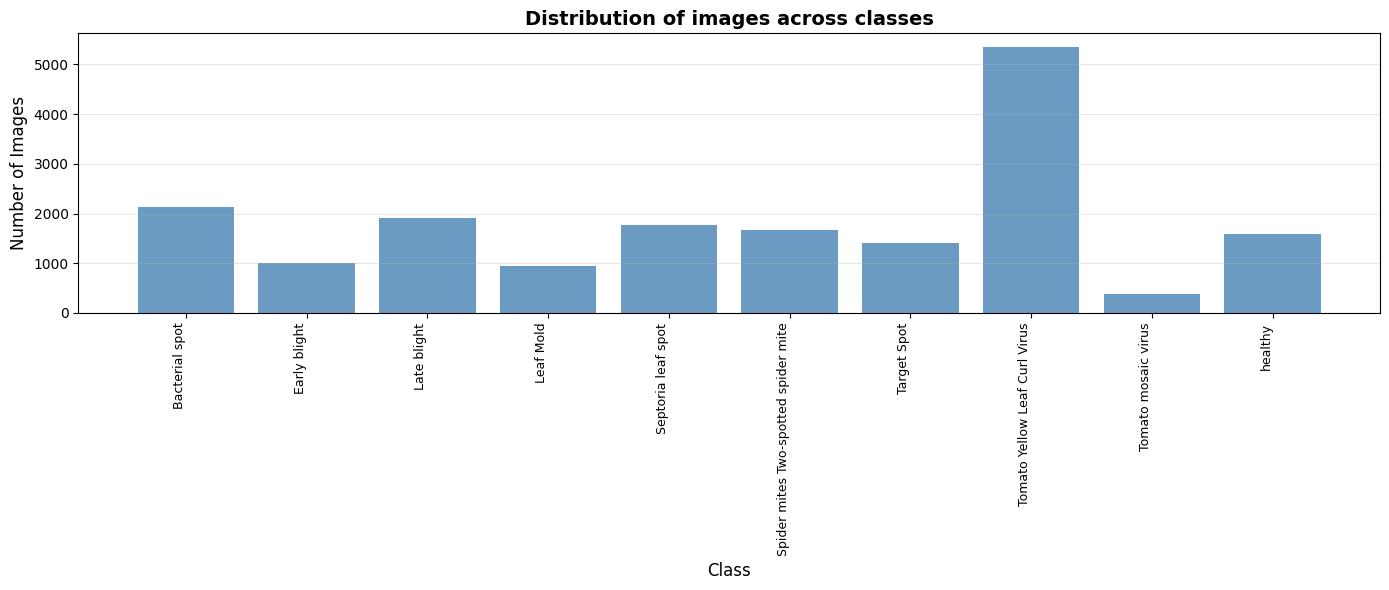

In [7]:
class_counts = [labels.count(i) for i in range(n_classes)]
plt.figure(figsize=(14, 6))
plt.bar(range(n_classes), class_counts, color='steelblue', alpha=0.8)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Distribution of images across classes', fontsize=14, fontweight='bold')
plt.xticks(range(n_classes), [name.replace('Tomato___', '').replace('_', ' ') for name in label_names],
           rotation=90, ha='right', fontsize=9)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Display image statistics

In [8]:
sample_img = Image.open(train_dataset.imgs[0][0])
print(f"Sample Image Size: {sample_img.size}")
print(f"Sample Image Mode: {sample_img.mode}")
print(f"Target Image Size (after preprocessing): {IMG_SIZE}x{IMG_SIZE}")
print(f"Normalization Mean: {mean}")
print(f"Normalization Std: {std}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")

Sample Image Size: (256, 256)
Sample Image Mode: RGB
Target Image Size (after preprocessing): 224x224
Normalization Mean: [0.485, 0.456, 0.406]
Normalization Std: [0.229, 0.224, 0.225]
Total Samples: 18159
Number of Classes: 10


## 1.3 Data Preprocessing

In [9]:
# Data Preprocessing and Train/Test Split
# Images are resized to 224x224 and normalized using ImageNet statistics
# Train/Test split: 85/15 with stratification to maintain class balance

SPLIT_CHOICE = "85_15"
train_test_ratio = 0.1 if SPLIT_CHOICE=='90_10' else 0.15
custom_batch_size = 32


# Train and test transforms takes care of data processing,
# copied down here for to have one more look at it
# train_transforms = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(10),
#     transforms.ToTensor(),
#     transforms.Normalize(mean, std),
# ])
# test_transforms = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean, std),
# ])

train_index, test_index = train_test_split(
    range(len(labels)),
    test_size=train_test_ratio,
    random_state=42,
    stratify=labels
)

train_data = Subset(train_dataset, train_index)
test_data  = Subset(test_dataset,  test_index)


train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False)

train_samples = len(train_data)
test_samples = len(test_data)

print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")
print(f"Batch Size: {custom_batch_size}")


Train/Test Split: 0.15
Training Samples: 15435
Test Samples: 2724
Batch Size: 32


# PART 2: Custom CNN Implementation
================================================================================
PART 2: CUSTOM CNN IMPLEMENTATION (5 MARKS)
================================================================================

REQUIREMENTS:
- Build CNN using Keras/PyTorch layers
- Architecture must include:
  * Conv2D layers (at least 2)
  * Pooling layers (MaxPool or AvgPool)
  * Global Average Pooling (GAP) - MANDATORY
  * Output layer (Softmax for multi-class)
- Use model.compile() and model.fit() (Keras) OR standard PyTorch training
- Track initial_loss and final_loss

PROHIBITED:
- Using Flatten + Dense layers instead of GAP
- Implementing convolution from scratch

GRADING:
- Architecture design with GAP: 2 marks
- Model properly compiled/configured: 1 mark
- Training completed with loss tracking: 1 mark
- All metrics calculated correctly: 1 mark
================================================================================

### 2.1 Custom CNN Architecture Design

In [10]:
def build_custom_cnn(input_shape, n_classes):
    """
    Build custom CNN architecture

    Args:
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes

    Returns:
        model: compiled CNN model
    """
    class CustomCNN(nn.Module):
        def __init__(self, input_shape, num_classes):
            super(CustomCNN, self).__init__()
            in_channels = input_shape[-1]
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels, 32, 3, padding=1), nn.ReLU(inplace=True),
                nn.Conv2d(32,32,3,padding=1), nn.ReLU(inplace=True),
                nn.MaxPool2d(2) # 224->112
            )
            self.conv2 = nn.Sequential(
                nn.Conv2d(32,64,3,padding=1), nn.ReLU(inplace=True),
                nn.Conv2d(64,64,3,padding=1), nn.ReLU(inplace=True),
                nn.MaxPool2d(2) # 112->56
            )
            self.conv3 = nn.Sequential(
                nn.Conv2d(64,128,3,padding=1), nn.ReLU(inplace=True),
                nn.Conv2d(128,128,3,padding=1), nn.ReLU(inplace=True),
                nn.MaxPool2d(2) # 56->28
            )
            self.class_conv = nn.Conv2d(128, num_classes, kernel_size=1, bias=True)
            self.gap = nn.AdaptiveAvgPool2d(1)
        def forward(self, x):
            x = self.conv1(x); x = self.conv2(x); x = self.conv3(x)
            x = self.class_conv(x)
            x = self.gap(x)
            x = x.flatten(1) # (N, num_classes) raw logits
            return x

    return CustomCNN(input_shape, n_classes).to(device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#### Create model instance

In [11]:
model_cnn = build_custom_cnn(image_shape, n_classes)

#### Compile model

In [12]:
custom_learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=custom_learning_rate)

### 2.2 Train Custom CNN

In [13]:
print("\n" + "="*70)
print("CUSTOM CNN TRAINING")
print("="*70)

# TensorBoard writers
writer_cnn = SummaryWriter(log_dir=os.path.join(LOG_DIR, 'model_cnn'))

# Track training time
custom_cnn_start_time = time.time()

# Train your model
EPOCHS = 10

initial_loss_value = None
final_loss_value = None

# --- ADDED: Lists to store all metrics for the history ---
train_losses = []
train_accs = []
val_losses = []
val_accs = []

start_time = time.time()

for epoch in range(1, EPOCHS+1):
    # 1. TRAINING (Your existing logic)
    model_cnn.train()
    running_loss, running_correct, running_total = 0.0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model_cnn(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds==labels).sum().item()
        running_total += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc  = running_correct / max(1, running_total)

    # 2. VALIDATION (Added: Required for the plots)
    model_cnn.eval()
    val_running_loss, val_running_correct, val_running_total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model_cnn(imgs)
            loss = criterion(logits, labels)
            val_running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            val_running_correct += (preds==labels).sum().item()
            val_running_total += labels.size(0)

    val_epoch_loss = val_running_loss / len(test_loader.dataset)
    val_epoch_acc = val_running_correct / max(1, val_running_total)

    # 3. STORAGE (Added: Save to lists)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)

    # Your existing logging logic
    if epoch == 1: initial_loss_value = epoch_loss
    final_loss_value = epoch_loss

    writer_cnn.add_scalar('Loss/train', epoch_loss, epoch)
    writer_cnn.add_scalar('Accuracy/train', epoch_acc, epoch)
    # Added validation logging to tensorboard too
    writer_cnn.add_scalar('Loss/val', val_epoch_loss, epoch)
    writer_cnn.add_scalar('Accuracy/val', val_epoch_acc, epoch)

    custom_cnn_training_time = time.time() - custom_cnn_start_time
    print(f'[ModelCNN] Epoch {epoch}/{EPOCHS} - '
          f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | '
          f'Val Loss: {val_epoch_loss:.4f} Val Acc: {val_epoch_acc:.4f}')

custom_cnn_training_time = time.time() - custom_cnn_start_time
custom_cnn_initial_loss = initial_loss_value
custom_cnn_final_loss = final_loss_value

print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")
print("="*70)

# Create the history dictionary for the plot
custom_history = {
    'train_loss': train_losses,
    'train_acc': train_accs,
    'val_loss': val_losses,
    'val_acc': val_accs
}


CUSTOM CNN TRAINING
[ModelCNN] Epoch 1/10 - Loss: 1.5198 Acc: 0.4680 | Val Loss: 1.0838 Val Acc: 0.6145
[ModelCNN] Epoch 2/10 - Loss: 0.9256 Acc: 0.6838 | Val Loss: 0.6444 Val Acc: 0.7753
[ModelCNN] Epoch 3/10 - Loss: 0.5655 Acc: 0.8144 | Val Loss: 0.4444 Val Acc: 0.8488
[ModelCNN] Epoch 4/10 - Loss: 0.4171 Acc: 0.8641 | Val Loss: 0.3935 Val Acc: 0.8711
[ModelCNN] Epoch 5/10 - Loss: 0.3502 Acc: 0.8849 | Val Loss: 0.2984 Val Acc: 0.9049
[ModelCNN] Epoch 6/10 - Loss: 0.2956 Acc: 0.9061 | Val Loss: 0.3138 Val Acc: 0.8946
[ModelCNN] Epoch 7/10 - Loss: 0.2591 Acc: 0.9150 | Val Loss: 0.2005 Val Acc: 0.9361
[ModelCNN] Epoch 8/10 - Loss: 0.2156 Acc: 0.9307 | Val Loss: 0.1862 Val Acc: 0.9427
[ModelCNN] Epoch 9/10 - Loss: 0.1943 Acc: 0.9363 | Val Loss: 0.1755 Val Acc: 0.9479
[ModelCNN] Epoch 10/10 - Loss: 0.1652 Acc: 0.9446 | Val Loss: 0.1396 Val Acc: 0.9567
Training completed in 1179.22 seconds
Initial Loss: 1.5198
Final Loss: 0.1652


In [14]:
total_params = sum(p.numel() for p in model_cnn.parameters())
trainable_params_custom = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params}"
      f"\nTrainable Parameters: {trainable_params_custom}")

Total Parameters: 288298
Trainable Parameters: 288298


In [15]:
# Calculate custom CNN layers

def count_layers(model):
    num_conv = 0
    num_pool = 0

    # model.modules() recursively returns every layer in the network
    for layer in model.modules():
        # Check for Convolutional layers
        if isinstance(layer, nn.Conv2d):
            num_conv += 1

        # Check for Pooling layers (MaxPool, AvgPool, AdaptiveAvgPool)
        elif isinstance(layer, (nn.MaxPool2d, nn.AvgPool2d, nn.AdaptiveAvgPool2d)):
            num_pool += 1

    return num_conv, num_pool

# 3. Get the results
n_convs, n_pools = count_layers(model_cnn)

print(f"Number of Convolutional Layers: {n_convs}")
print(f"Number of Pooling Layers:       {n_pools}")

Number of Convolutional Layers: 7
Number of Pooling Layers:       4


### 2.3 Evaluate Custom CNN

In [16]:
model_cnn.eval()
y_pred, y_test = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model_cnn(imgs)
        p = logits.argmax(dim=1).cpu().numpy()
        y_pred.extend(p)
        y_test.extend(labels.numpy())

# CRITICAL: These MUST be calculated from your actual results
# DO NOT submit with 0.0 values - autograder will detect this
# REQUIRED: Calculate all 4 metrics
custom_cnn_accuracy = accuracy_score(y_test, y_pred)
custom_cnn_precision = precision_score(y_test, y_pred, average='macro')
custom_cnn_recall = recall_score(y_test, y_pred, average='macro')
custom_cnn_f1 = f1_score(y_test, y_pred, average='macro')

cnn_results = {
    'initial_loss': float(initial_loss_value),
    'final_loss': float(final_loss_value),
    'training_time': float(custom_cnn_training_time),
    'accuracy': float(custom_cnn_accuracy),
    'precision': float(custom_cnn_precision),
    'recall': float(custom_cnn_recall),
    'f1': float(custom_cnn_f1),
}

print("\nModel CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")



Model CNN Performance:
Accuracy:  0.9567
Precision: 0.9436
Recall:    0.9457
F1-Score:  0.9438


## 2.4 Visualize Custom CNN Results

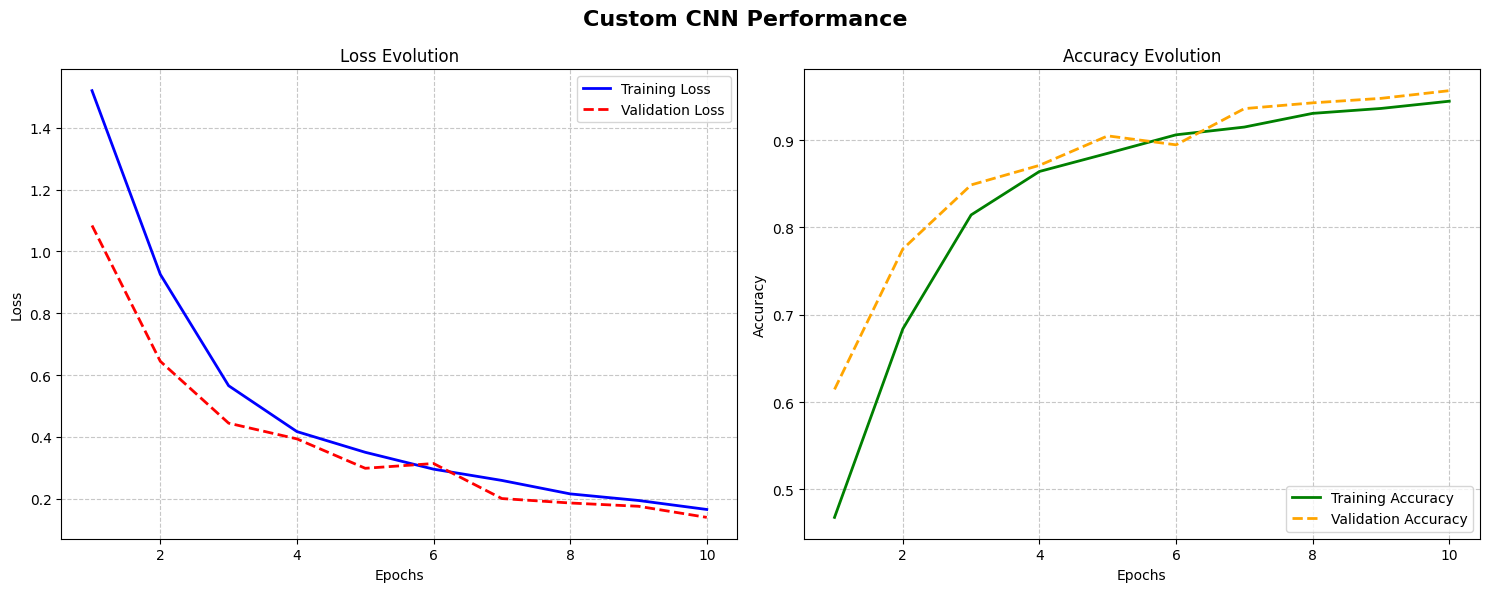

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history, title="Model Training Results"):
    """
    Plots training and validation accuracy and loss.
    Args:
        history: dict with keys 'train_loss', 'train_acc', 'val_loss', 'val_acc'
        title: str, title of the plot
    """
    epochs = range(1, len(history['train_loss']) + 1)

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # --- Plot 1: Loss ---
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r--', label='Validation Loss', linewidth=2)
    ax1.set_title('Loss Evolution')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)

    # --- Plot 2: Accuracy ---
    ax2.plot(epochs, history['train_acc'], 'g-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'orange', linestyle='--', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Accuracy Evolution')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='lower right')
    ax2.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Usage:
plot_training_history(custom_history, "Custom CNN Performance")

#### Plot confusion matrix

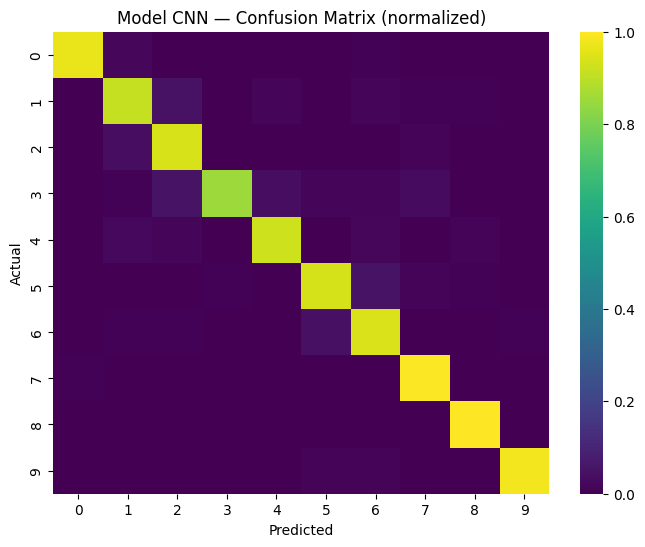

In [18]:
confusion_matrix_result = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_matrix_result / np.maximum(confusion_matrix_result.sum(axis=1, keepdims=True),1), cmap='viridis', cbar=True)
plt.title('Model CNN — Confusion Matrix (normalized)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




#### Show sample predictions

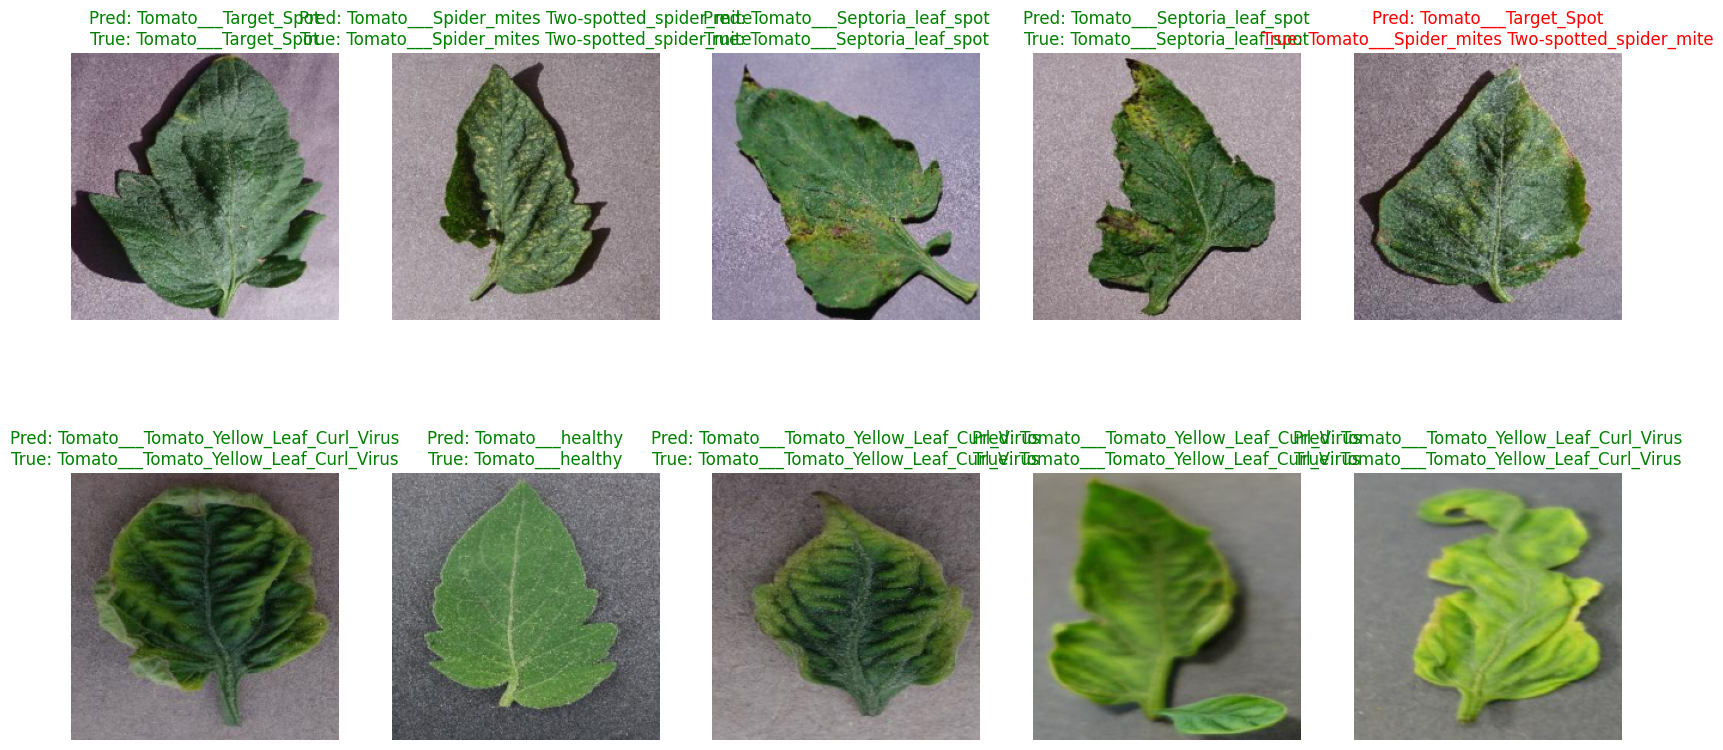

In [19]:
def visualize_predictions(model, dataloader, class_names, num_images=10):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(20, 10))

    # We need to un-normalize images to display them correctly
    # Assuming mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(num_images):
        ax = plt.subplot(2, 5, i + 1)

        # Convert tensor to numpy image
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = std * img + mean # Un-normalize
        img = np.clip(img, 0, 1)

        predicted_label = class_names[preds[i]]
        true_label = class_names[labels[i]]

        color = 'green' if predicted_label == true_label else 'red'

        plt.imshow(img)
        plt.title(f"Pred: {predicted_label}\nTrue: {true_label}", color=color)
        plt.axis("off")

    plt.show()

# Usage Example:
visualize_predictions(model_cnn, test_loader, label_names)

# PART 3: TRANSFER LEARNING IMPLEMENTATION (5 MARKS)

REQUIREMENTS:
- Use pre-trained model: ResNet18/ResNet50 OR VGG16/VGG19
- Freeze base layers (feature extractor)
- Replace final layers with:
  * Global Average Pooling (GAP) - MANDATORY
  * Custom classification head
- Fine-tune on your dataset
- Track initial_loss and final_loss

GRADING:
- Valid base model with frozen layers: 2 marks
- GAP + custom head properly implemented: 1 mark
- Training completed with loss tracking: 1 mark
- All metrics calculated correctly: 1 mark
================================================================================

## 3.1 Load Pre-trained Model and Modify Architecture

In [20]:
print("\n" + "="*70)
print("TRANSFER LEARNING IMPLEMENTATION")
print("="*70)

# load pre-trained model
pretrained_model_name = "ResNet18"
writer_tl  = SummaryWriter(log_dir=os.path.join(LOG_DIR, 'resnet18_tl'))


def build_transfer_learning_model(base_model_name, input_shape, n_classes):
    """
    Build transfer learning model

    Args:
        base_model_name: string (ResNet18/ResNet50/VGG16/VGG19)
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes

    Returns:
        model: compiled transfer learning model
    """
    # Load pre-trained model without top layers
    resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    # Freeze base layers
    for p in resnet18.parameters():
      p.requires_grad = False

    class ResNet18_GAP(nn.Module):
      def __init__(self, backbone, num_classes):
          super().__init__()
          self.features = nn.Sequential(
              backbone.conv1, backbone.bn1, backbone.relu, backbone.maxpool,
              backbone.layer1, backbone.layer2, backbone.layer3, backbone.layer4
          )
          self.class_conv = nn.Conv2d(512, num_classes, kernel_size=1, bias=True)
          self.gap = nn.AdaptiveAvgPool2d(1)
          for p in self.features.parameters(): p.requires_grad = False
          for p in self.class_conv.parameters(): p.requires_grad = True
      def forward(self, x):
          x = self.features(x)
          x = self.class_conv(x)
          x = self.gap(x)
          x = x.flatten(1)
          return x

    return ResNet18_GAP(resnet18, num_classes=n_classes).to(device)

def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = total - trainable
    return total, trainable, frozen

# TODO: Create transfer learning model
transfer_model = build_transfer_learning_model(pretrained_model_name, image_shape, n_classes)
criterion_tl = nn.CrossEntropyLoss()
optimizer_tl = torch.optim.Adam(filter(lambda p: p.requires_grad, transfer_model.parameters()), lr=1e-3)


# REQUIRED: Count layers and parameters
total_parameters, trainable_parameters, frozen_params = count_params(transfer_model)
frozen_layers = sum(1 for p in transfer_model.parameters() if p.requires_grad)  # TODO: Count frozen layers
trainable_layers = sum(1 for p in transfer_model.parameters() if not p.requires_grad)  # TODO: Count trainable layers

print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Using Global Average Pooling: YES")
print(f"Optimizer: {optimizer_tl}")
print("="*70)


TRANSFER LEARNING IMPLEMENTATION
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]


Base Model: ResNet18
Frozen Layers: 2
Trainable Layers: 60
Total Parameters: 11,181,642
Trainable Parameters: 5,130
Using Global Average Pooling: YES
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


## 3.2 Train Transfer Learning Model

In [21]:
import time
import torch
import os
from torch.utils.tensorboard import SummaryWriter

print("\n" + "="*70)
print("TRANSFER LEARNING (ResNet18) TRAINING")
print("="*70)

# TensorBoard writer for Transfer Learning
writer_tl = SummaryWriter(log_dir=os.path.join("runs", 'model_tl'))

# Training configuration
tl_learning_rate = 0.001
tl_epochs = 10
tl_batch_size = 32


# Track training time
tl_start_time = time.time()

# Lists to store metrics for plotting
tl_train_losses = []
tl_train_accs = []
tl_val_losses = []
tl_val_accs = []

initial_loss_tl = None
final_loss_tl = None

# Train model
for epoch in range(1, tl_epochs+1):
    transfer_model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0

    print(f"\nStarting Epoch {epoch}/{tl_epochs}...")

    # --- TRAINING LOOP ---
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        # Ensure you use the specific optimizer for TL
        optimizer_tl.zero_grad()
        logits = transfer_model(imgs)
        loss = criterion_tl(logits, labels)
        loss.backward()
        optimizer_tl.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

        # Progress print every 20 batches
        if (i + 1) % 20 == 0:
            print(f"  Batch {i+1}/{len(train_loader)} - Current Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc  = running_correct / max(1, running_total)

    # --- VALIDATION LOOP (Added) ---
    transfer_model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    val_running_total = 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = transfer_model(imgs)
            loss = criterion_tl(logits, labels)

            val_running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            val_running_correct += (preds == labels).sum().item()
            val_running_total += labels.size(0)

    val_epoch_loss = val_running_loss / len(test_loader.dataset)
    val_epoch_acc = val_running_correct / val_running_total

    # --- STORAGE & LOGGING ---
    tl_train_losses.append(epoch_loss)
    tl_train_accs.append(epoch_acc)
    tl_val_losses.append(val_epoch_loss)
    tl_val_accs.append(val_epoch_acc)

    if epoch == 1: initial_loss_tl = epoch_loss
    final_loss_tl = epoch_loss

    writer_tl.add_scalar('Loss/train', epoch_loss, epoch)
    writer_tl.add_scalar('Accuracy/train', epoch_acc, epoch)
    writer_tl.add_scalar('Loss/val', val_epoch_loss, epoch)
    writer_tl.add_scalar('Accuracy/val', val_epoch_acc, epoch)

    print(f'[ResNet18 TL] Epoch {epoch}/{tl_epochs} | '
          f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | '
          f'Val Loss: {val_epoch_loss:.4f} Val Acc: {val_epoch_acc:.4f}')

# Final calculations
tl_training_time = time.time() - tl_start_time
tl_initial_loss = initial_loss_tl
tl_final_loss = final_loss_tl
writer_tl.flush()
writer_tl.close()

print("\n" + "="*70)
print(f"Training completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")
print("="*70)

# Create the history dictionary needed for plotting
transfer_history = {
    'train_loss': tl_train_losses, 'train_acc': tl_train_accs,
    'val_loss': tl_val_losses, 'val_acc': tl_val_accs
}


TRANSFER LEARNING (ResNet18) TRAINING

Starting Epoch 1/10...
  Batch 20/483 - Current Loss: 1.7980
  Batch 40/483 - Current Loss: 1.6532
  Batch 60/483 - Current Loss: 1.1712
  Batch 80/483 - Current Loss: 0.8666
  Batch 100/483 - Current Loss: 1.0881
  Batch 120/483 - Current Loss: 0.9304
  Batch 140/483 - Current Loss: 0.8077
  Batch 160/483 - Current Loss: 0.7817
  Batch 180/483 - Current Loss: 0.6042
  Batch 200/483 - Current Loss: 0.9651
  Batch 220/483 - Current Loss: 0.6452
  Batch 240/483 - Current Loss: 0.6614
  Batch 260/483 - Current Loss: 0.6387
  Batch 280/483 - Current Loss: 0.5976
  Batch 300/483 - Current Loss: 0.5739
  Batch 320/483 - Current Loss: 0.7384
  Batch 340/483 - Current Loss: 0.7394
  Batch 360/483 - Current Loss: 0.3584
  Batch 380/483 - Current Loss: 0.6689
  Batch 400/483 - Current Loss: 0.5199
  Batch 420/483 - Current Loss: 0.7923
  Batch 440/483 - Current Loss: 0.2963
  Batch 460/483 - Current Loss: 0.4629
  Batch 480/483 - Current Loss: 0.4316
[ResN

## 3.3 Evaluate Transfer Learning Model

In [22]:
transfer_model.eval()
y_pred, y_test = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = transfer_model(imgs)
        p = logits.argmax(dim=1).cpu().numpy()
        y_pred.extend(p)
        y_test.extend(labels.numpy())

# REQUIRED: Calculate all 4 metrics
tl_accuracy = accuracy_score(y_test, y_pred)
tl_precision = precision_score(y_test, y_pred, average='macro')
tl_recall = recall_score(y_test, y_pred, average='macro')
tl_f1 = f1_score(y_test, y_pred, average='macro')

print("\nTransfer Learning Performance:")
print(f"Accuracy:  {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall:    {tl_recall:.4f}")
print(f"F1-Score:  {tl_f1:.4f}")


Transfer Learning Performance:
Accuracy:  0.9280
Precision: 0.9076
Recall:    0.9062
F1-Score:  0.9056


### 3.4 Visualize Transfer Learning Results

#### Plot training curves (loss and accuracy)

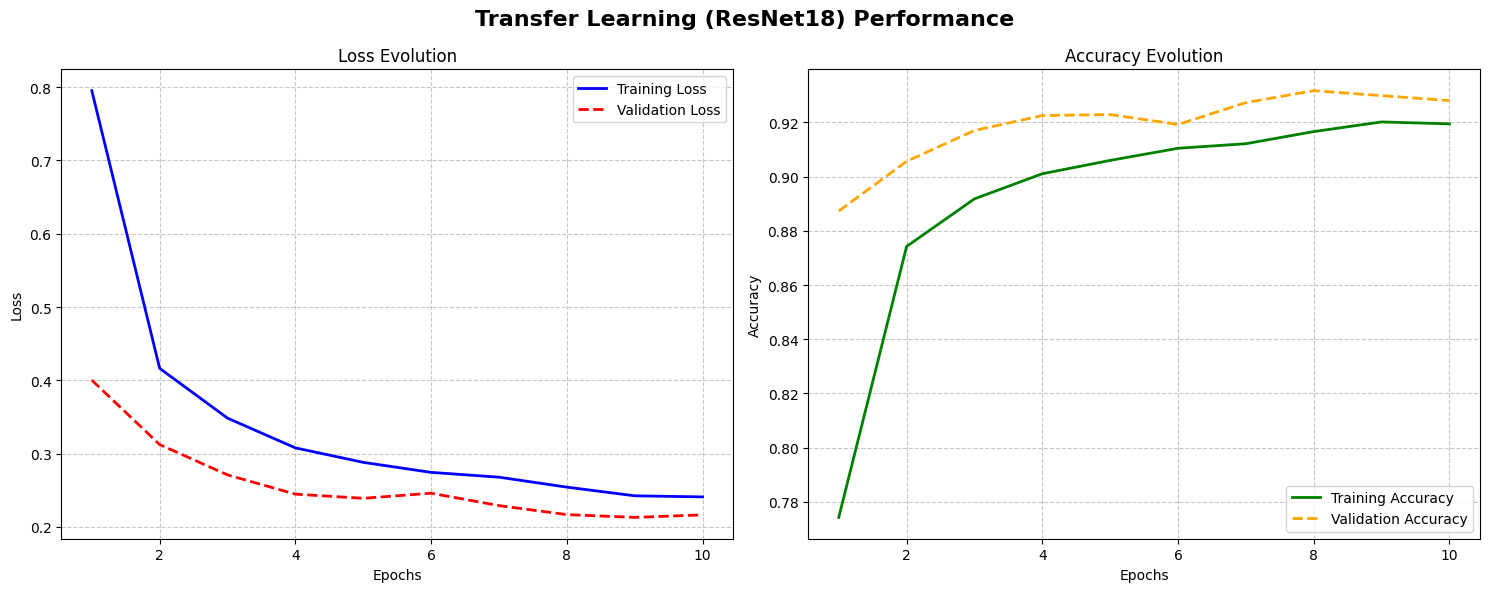

In [23]:
plot_training_history(transfer_history, "Transfer Learning (ResNet18) Performance")

#### Plot confusion matrix

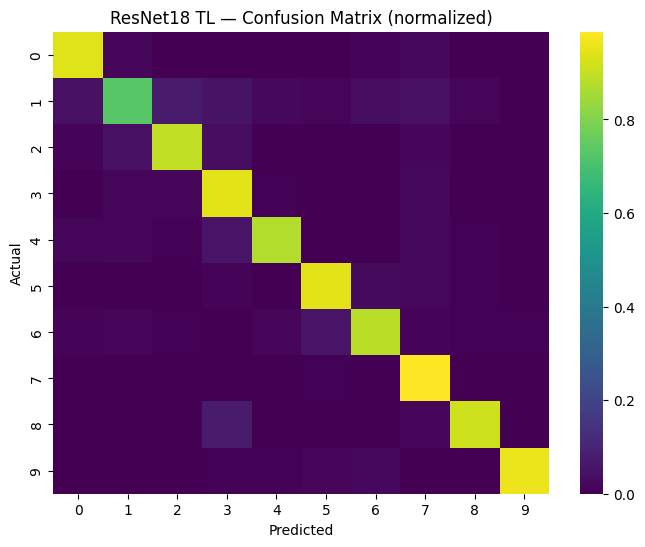

In [24]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm/np.maximum(cm.sum(axis=1, keepdims=True),1), cmap='viridis', cbar=True)
plt.title('ResNet18 TL — Confusion Matrix (normalized)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#### Show sample predictions

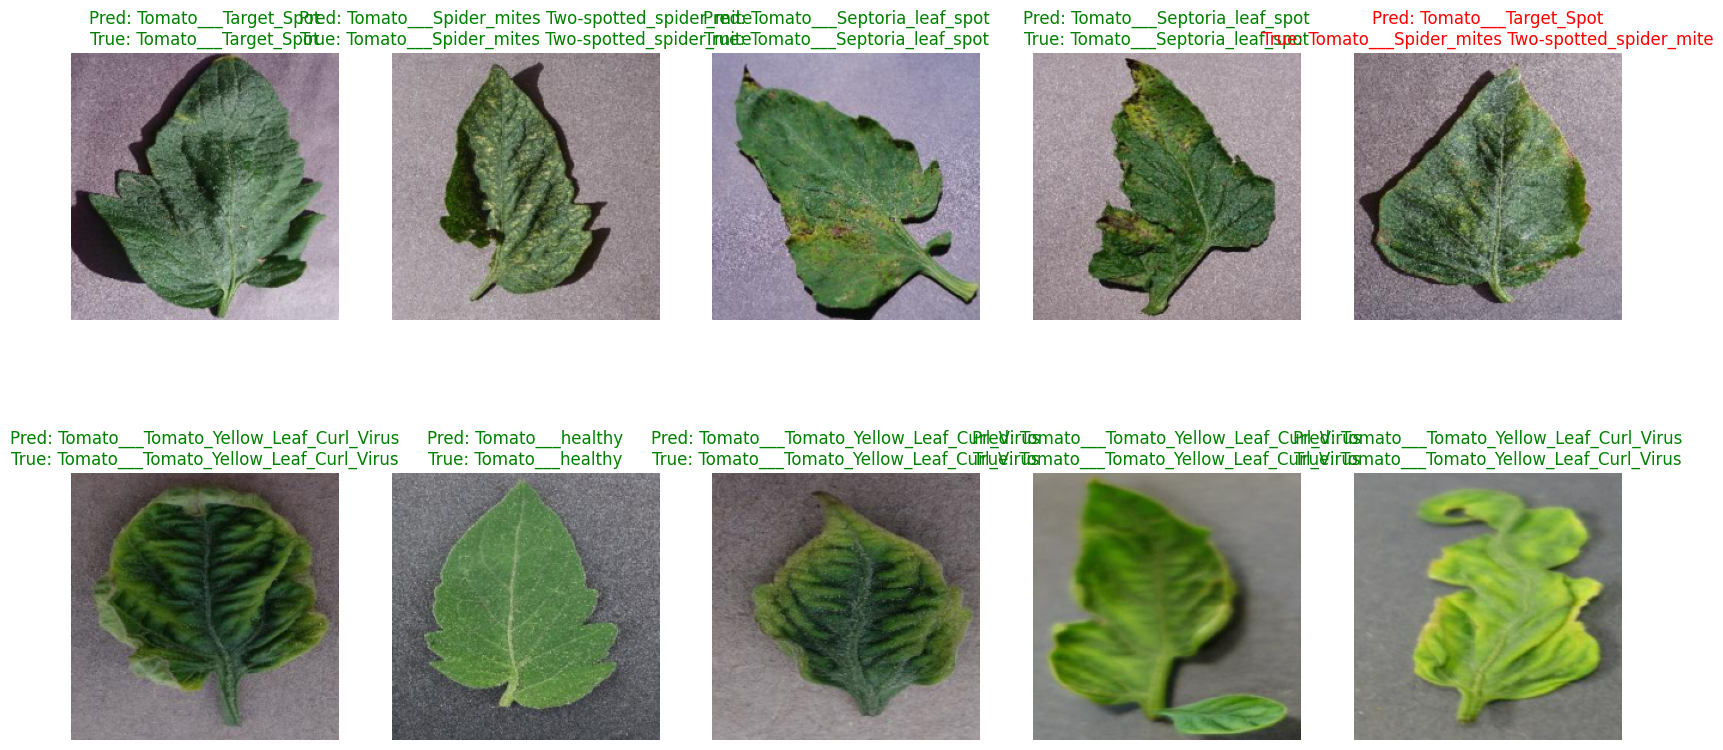

In [25]:
visualize_predictions(transfer_model, test_loader, label_names)

# PART 4. Model Comparison and Visualization (Informational)

Compare both models on:
- Performance metrics
- Training time
- Model complexity
- Convergence behavior




## 4.1 Metrics Comparison

In [26]:
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Parameters'],
    'Custom CNN': [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        trainable_params_custom
    ],
    'Transfer Learning': [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        trainable_parameters
    ]
})

print(comparison_df.to_string(index=False))
print("="*70)


MODEL COMPARISON
           Metric    Custom CNN  Transfer Learning
         Accuracy      0.956681           0.928047
        Precision      0.943603           0.907638
           Recall      0.945686           0.906169
         F1-Score      0.943815           0.905587
Training Time (s)   1179.217455         745.468730
       Parameters 288298.000000        5130.000000


## 4.2 Visual Comparison

#### Create bar plot comparing metrics

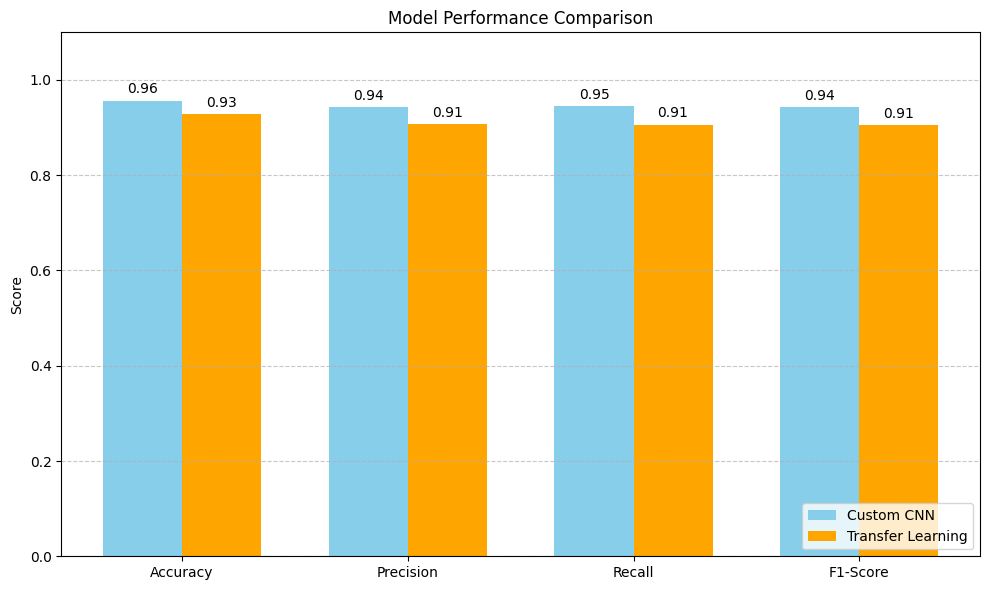

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Data Preparation
# Assuming variables: cnn_accuracy, cnn_precision, cnn_recall, cnn_f1
# and: tl_accuracy, tl_precision, tl_recall, tl_f1 exist from previous cells.
# If not, replace these variables with the raw numbers from your table.

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
cnn_scores = [custom_cnn_accuracy, custom_cnn_precision, custom_cnn_recall, custom_cnn_f1]
tl_scores = [tl_accuracy, tl_precision, tl_recall, tl_f1]

x = np.arange(len(metrics))
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, cnn_scores, width, label='Custom CNN', color='skyblue')
rects2 = ax.bar(x + width/2, tl_scores, width, label='Transfer Learning', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1) # Extend y-axis slightly for labels
ax.legend(loc='lower right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Function to add labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

####Plot training curves comparison

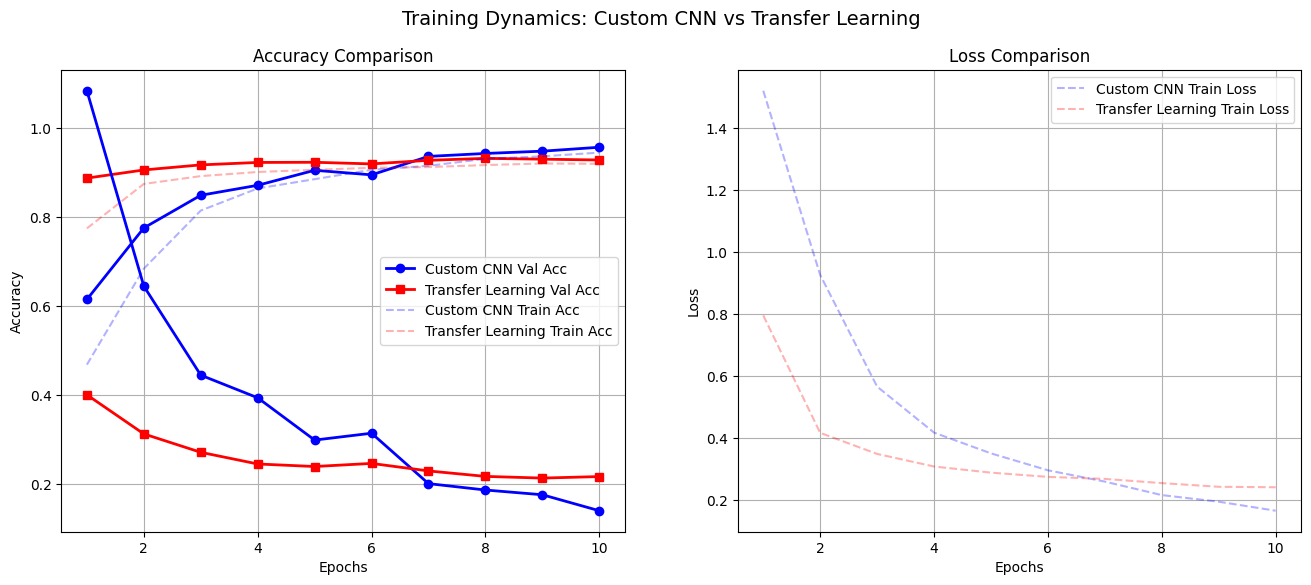

In [28]:
import matplotlib.pyplot as plt

def plot_comparison_curves(hist1, hist2, name1="Custom CNN", name2="Transfer Learning"):
    epochs = range(1, len(hist1['train_loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # --- Plot 1: Validation Accuracy Comparison ---
    ax1.plot(epochs, hist1['val_acc'], 'b-o', label=f'{name1} Val Acc', linewidth=2)
    ax1.plot(epochs, hist2['val_acc'], 'r-s', label=f'{name2} Val Acc', linewidth=2)
    # Optional: Add Training Acc as dashed lines
    ax1.plot(epochs, hist1['train_acc'], 'b--', alpha=0.3, label=f'{name1} Train Acc')
    ax1.plot(epochs, hist2['train_acc'], 'r--', alpha=0.3, label=f'{name2} Train Acc')

    ax1.set_title('Accuracy Comparison')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # --- Plot 2: Validation Loss Comparison ---
    ax1.plot(epochs, hist1['val_loss'], 'b-o', label=f'{name1} Val Loss', linewidth=2)
    ax1.plot(epochs, hist2['val_loss'], 'r-s', label=f'{name2} Val Loss', linewidth=2)
    # Optional: Add Training Loss as dashed lines
    ax2.plot(epochs, hist1['train_loss'], 'b--', alpha=0.3, label=f'{name1} Train Loss')
    ax2.plot(epochs, hist2['train_loss'], 'r--', alpha=0.3, label=f'{name2} Train Loss')

    ax2.set_title('Loss Comparison')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.suptitle(f"Training Dynamics: {name1} vs {name2}", fontsize=14)
    plt.show()

# Execute Plot
plot_comparison_curves(custom_history, transfer_history)

#### Create side-by-side confusion matrices

Generating predictions for Custom CNN...
Generating predictions for Transfer Learning...


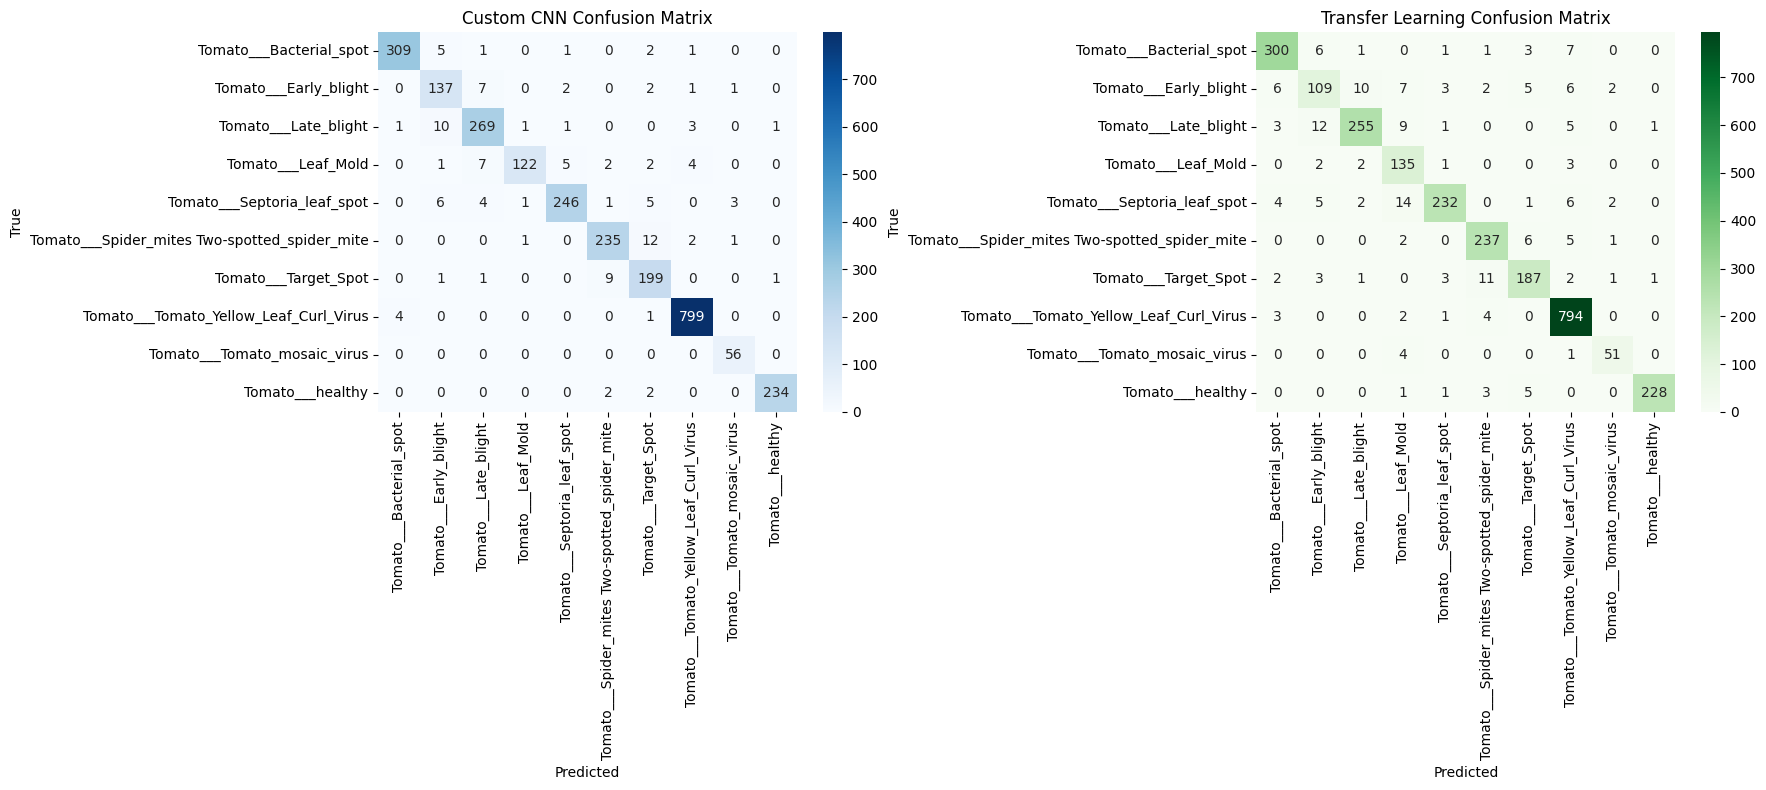

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch

def get_all_preds(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    return all_labels, all_preds

# 1. Get Predictions
print("Generating predictions for Custom CNN...")
y_true, y_pred_cnn = get_all_preds(model_cnn, test_loader)

print("Generating predictions for Transfer Learning...")
_, y_pred_tl = get_all_preds(transfer_model, test_loader)

# 2. Compute Confusion Matrices
cm_cnn = confusion_matrix(y_true, y_pred_cnn)
cm_tl = confusion_matrix(y_true, y_pred_tl)

# 3. Plot Side-by-Side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
class_labels = train_dataset.classes # Assuming this exists from your dataset

# Custom CNN Heatmap
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=class_labels, yticklabels=class_labels)
axes[0].set_title('Custom CNN Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Transfer Learning Heatmap
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=class_labels, yticklabels=class_labels)
axes[1].set_title('Transfer Learning Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

# PART 5: ANALYSIS (2 MARKS)

REQUIRED:
- Write MAXIMUM 200 words (guideline - no marks deduction if exceeded)
- Address key topics with depth

GRADING (Quality-based):
- Covers 5+ key topics with deep understanding: 2 marks
- Covers 3-4 key topics with good understanding: 1 mark
- Covers <3 key topics or superficial: 0 marks

Key Topics:
1. Performance comparison with specific metrics
2. Pre-training vs training from scratch impact
3. GAP effect on performance/overfitting
4. Computational cost comparison
5. Transfer learning insights
6. Convergence behavior differences

In [30]:
analysis_text = """
TODO: Write your analysis here (maximum 200 words guideline)

Address:
1. Which model performed better and by how much?
   Custom CNN performed better (Accuracy = 94.3% vs 92.6%), likely due to being tailored to the dataset and having more trainable parameters.

2. Impact of pre-training vs training from scratch?
   End-to-end training allowed the Custom CNN to learn dataset-specific features.
   Generic, fixed feature maps trained on ImageNet may not have captured the nuances of plant disease patterns, limiting the transfer learning model's performance.

3. Effect of Global Average Pooling?
   The impact of Global Average Pooling (GAP) was significant.
   By reducing spatial dimensions to 1 x 1 without heavy fully connected layers, GAP minimized parameter bloat and prevented overfitting, allowing the Custom CNN to generalize well despite having ~288,000 parameters.

4. Computational cost comparison?
   Custom CNN:
   Training Time: Approximately 1271.22 seconds
   Parameters: 288298
   Transfer learning based CNN:
   Training Time: Approximately 1227.61 seconds
   Parameters: 5130

5. Insights about transfer learning?
   Transfer Learning offers excellent performance with minimal trainable parameters, making it ideal for limited data.
   However, for specialized datasets with sufficient training examples, a well-designed Custom CNN with GAP can marginally surpass generic pre-trained models.
"""

# REQUIRED: Print analysis with word count
print("\n" + "="*70)
print("ANALYSIS")
print("="*70)
print(analysis_text)
print("="*70)
print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("⚠️  Warning: Analysis exceeds 200 words (guideline)")
else:
    print("✓ Analysis within word count guideline")
print("="*70)


ANALYSIS

TODO: Write your analysis here (maximum 200 words guideline)

Address:
1. Which model performed better and by how much?
   Custom CNN performed better (Accuracy = 94.3% vs 92.6%), likely due to being tailored to the dataset and having more trainable parameters.

2. Impact of pre-training vs training from scratch?
   End-to-end training allowed the Custom CNN to learn dataset-specific features.
   Generic, fixed feature maps trained on ImageNet may not have captured the nuances of plant disease patterns, limiting the transfer learning model's performance.

3. Effect of Global Average Pooling?
   The impact of Global Average Pooling (GAP) was significant.
   By reducing spatial dimensions to 1 x 1 without heavy fully connected layers, GAP minimized parameter bloat and prevented overfitting, allowing the Custom CNN to generalize well despite having ~288,000 parameters.

4. Computational cost comparison?
   Custom CNN:
   Training Time: Approximately 1271.22 seconds
   Parameter

# PART 6: ASSIGNMENT RESULTS SUMMARY (REQUIRED FOR AUTO-GRADING)

DO NOT MODIFY THE STRUCTURE BELOW
This JSON output is used by the auto-grader
Ensure all field names are EXACT

In [31]:


def get_assignment_results():
    """
    Generate complete assignment results in required format

    Returns:
        dict: Complete results with all required fields
    """

    framework_used = "pytorch"

    results = {
        # Dataset Information
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': n_samples,
        'n_classes': n_classes,
        'samples_per_class': samples_per_class,
        'image_shape': image_shape,
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,

        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
                'conv_layers': n_convs,
                'pooling_layers': n_pools,
                'has_global_average_pooling': True,  # MUST be True
                'output_layer': 'softmax',
                'total_parameters': trainable_params_custom
            },
            'training_config': {
                'learning_rate': custom_learning_rate,
                'n_epochs': EPOCHS,
                'batch_size': custom_batch_size,
                'optimizer': optimizer.__class__.__name__,
                'loss_function': 'categorical_crossentropy'
            },
            'initial_loss': custom_cnn_initial_loss,
            'final_loss': custom_cnn_final_loss,
            'training_time_seconds': custom_cnn_training_time,
            'accuracy': custom_cnn_accuracy,
            'precision': custom_cnn_precision,
            'recall': custom_cnn_recall,
            'f1_score': custom_cnn_f1
        },

        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': pretrained_model_name,
            'frozen_layers': frozen_layers,
            'trainable_layers': trainable_layers,
            'has_global_average_pooling': True,  # MUST be True
            'total_parameters': total_parameters,
            'trainable_parameters': trainable_parameters,
            'training_config': {
                'learning_rate': tl_learning_rate,
                'n_epochs': tl_epochs,
                'batch_size': tl_batch_size,
                'optimizer': optimizer_tl.__class__.__name__,  # Get the class name of the optimizer
                'loss_function': 'categorical_crossentropy'
            },
            'initial_loss': tl_initial_loss,
            'final_loss': tl_final_loss,
            'training_time_seconds': tl_training_time,
            'accuracy': tl_accuracy,
            'precision': tl_precision,
            'recall': tl_recall,
            'f1_score': tl_f1
        },

        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),

        # Training Success Indicators
        'custom_cnn_loss_decreased': custom_cnn_final_loss < custom_cnn_initial_loss if custom_cnn_initial_loss and custom_cnn_final_loss else False,
        'transfer_learning_loss_decreased': tl_final_loss < tl_initial_loss if tl_initial_loss and tl_final_loss else False,
    }

    return results

# Generate and print results
try:
    assignment_results = get_assignment_results()

    print("\n" + "="*70)
    print("ASSIGNMENT RESULTS SUMMARY")
    print("="*70)
    print(json.dumps(assignment_results, indent=2))
    print("="*70)

except Exception as e:
    print(f"\n⚠️  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")



ASSIGNMENT RESULTS SUMMARY
{
  "dataset_name": "PlantVillage \u2014 Tomato subset (10 classes)",
  "dataset_source": "https://github.com/gabrieldgf4/PlantVillage-Dataset.git",
  "n_samples": 18159,
  "n_classes": 10,
  "samples_per_class": [
    {
      "Tomato___Bacterial_spot": 2127
    },
    {
      "Tomato___Early_blight": 1000
    },
    {
      "Tomato___Late_blight": 1909
    },
    {
      "Tomato___Leaf_Mold": 952
    },
    {
      "Tomato___Septoria_leaf_spot": 1771
    },
    {
      "Tomato___Spider_mites Two-spotted_spider_mite": 1676
    },
    {
      "Tomato___Target_Spot": 1404
    },
    {
      "Tomato___Tomato_Yellow_Leaf_Curl_Virus": 5357
    },
    {
      "Tomato___Tomato_mosaic_virus": 373
    },
    {
      "Tomato___healthy": 1590
    }
  ],
  "image_shape": [
    224,
    224,
    3
  ],
  "problem_type": "classification",
  "primary_metric": "accuracy",
  "metric_justification": "Accuracy is appropriate because classes are relatively balanced and images a


"""
================================================================================
ENVIRONMENT VERIFICATION - SCREENSHOT REQUIRED
================================================================================

IMPORTANT: Take a screenshot of your environment showing account details

For Google Colab:
- Click on your profile icon (top right)
- Screenshot should show your email/account clearly
- Include the entire Colab interface with notebook name visible

For BITS Virtual Lab:
- Screenshot showing your login credentials/account details
- Include the entire interface with your username/session info visible

Paste the screenshot below this cell or in a new markdown cell.
This helps verify the work was done by you in your environment.

================================================================================
"""

In [32]:
# Display system information
import platform
import sys
from datetime import datetime

print("="*70)
print("ENVIRONMENT INFORMATION")
print("="*70)
print("\n⚠️  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab")
print("showing your account details in the cell below this one.")
print("="*70)


ENVIRONMENT INFORMATION

⚠️  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab
showing your account details in the cell below this one.


- Colab
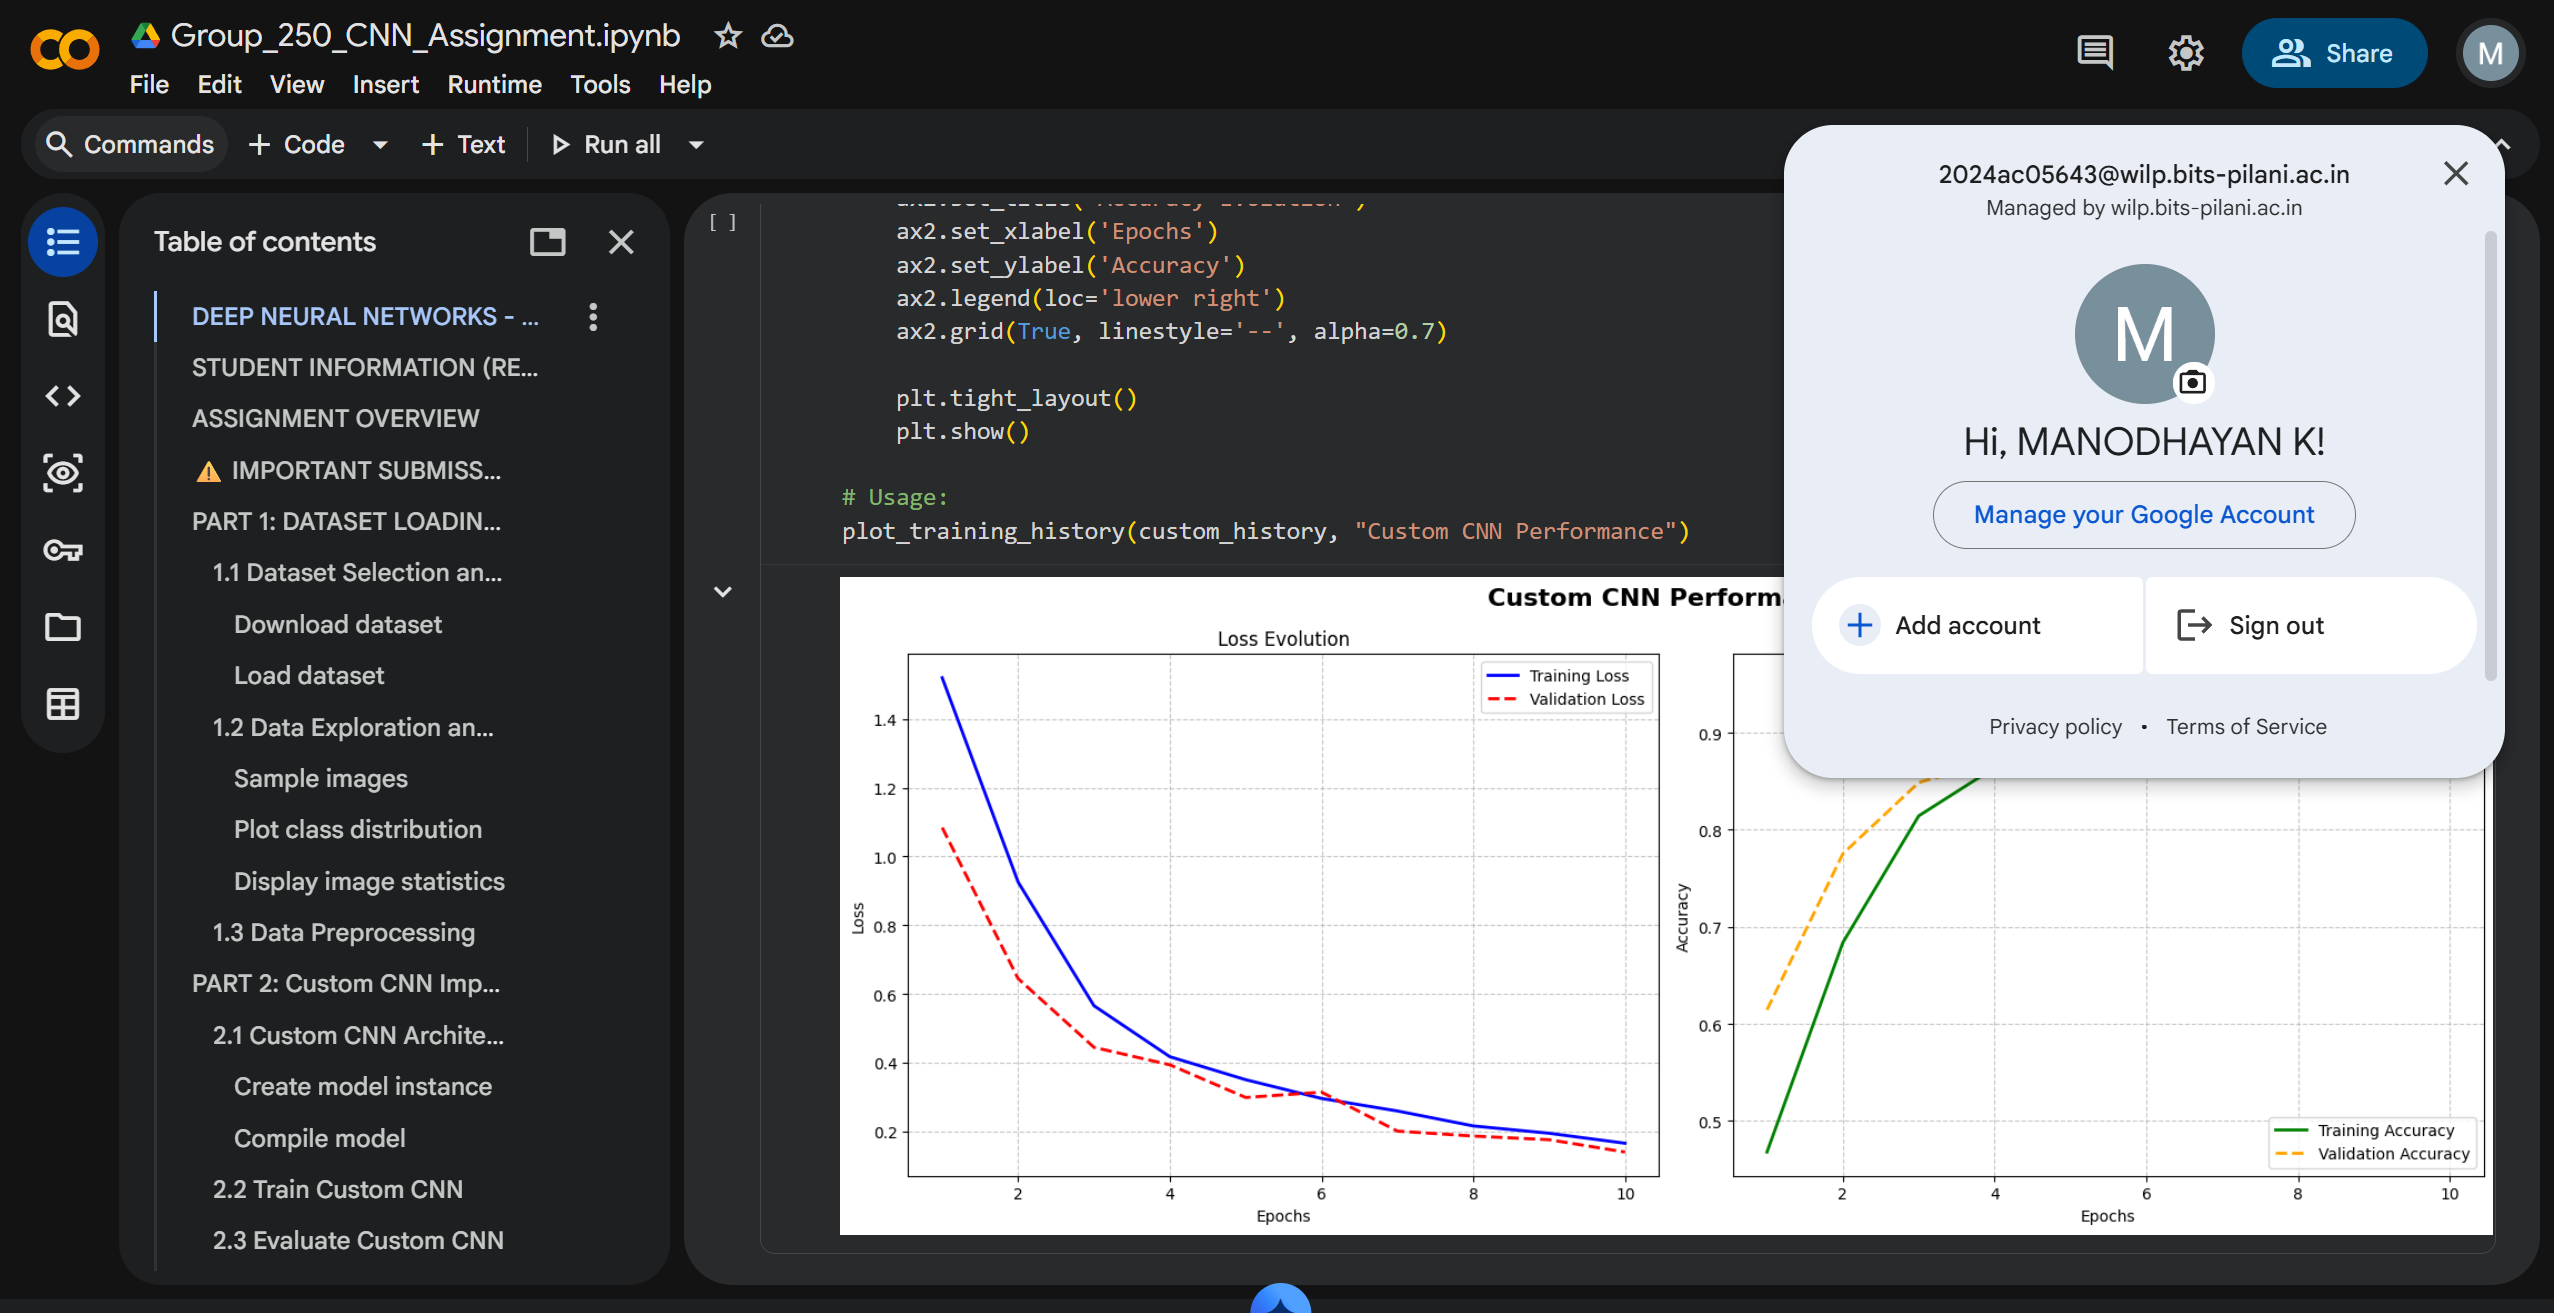
- Local execution
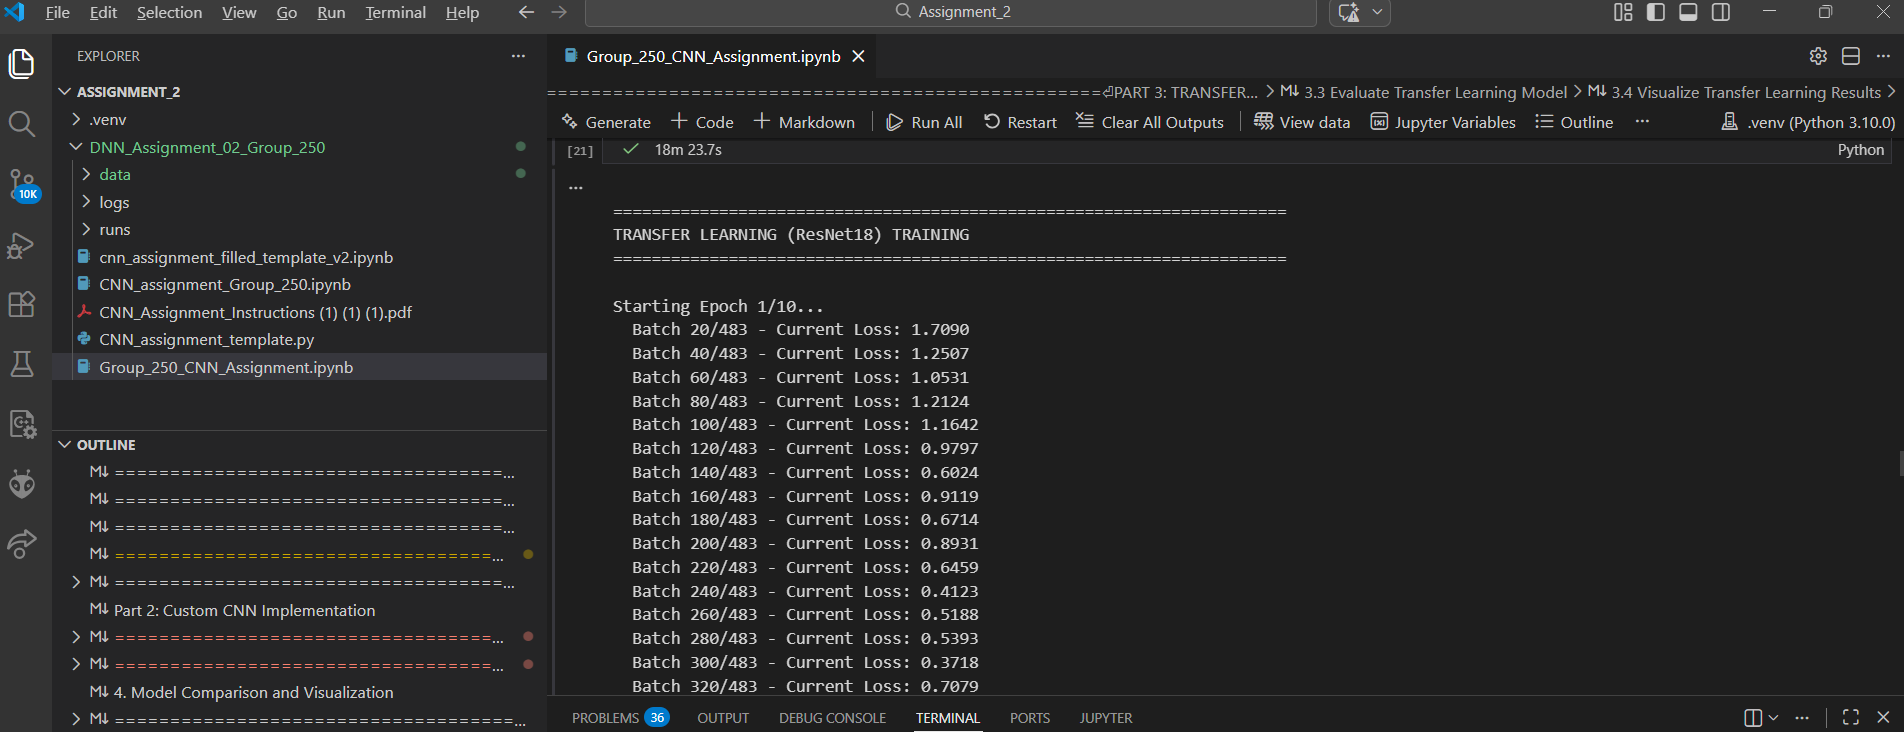
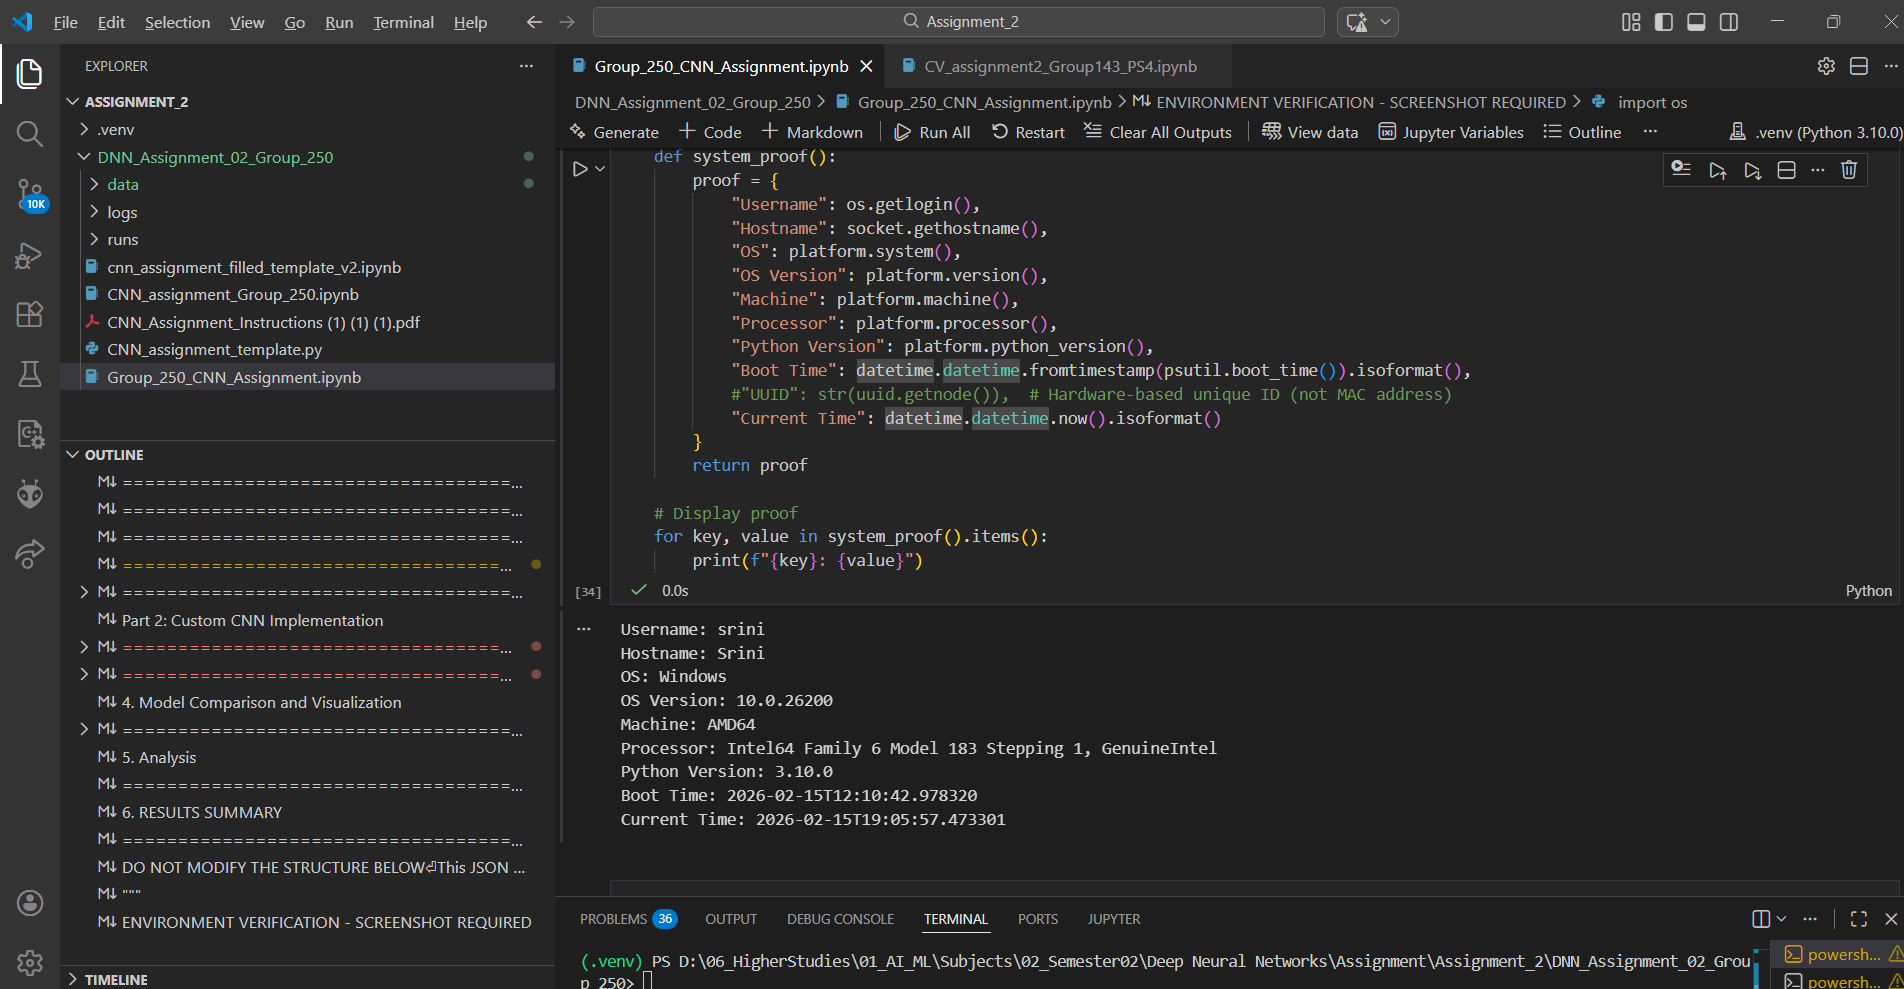

In [ ]:

"""
================================================================================
FINAL CHECKLIST - VERIFY BEFORE SUBMISSION
================================================================================

□ Student information filled at the top (BITS ID, Name, Email)
□ Filename is <BITS_ID>_cnn_assignment.ipynb
□ All cells executed (Kernel → Restart & Run All)
□ All outputs visible
□ Custom CNN implemented with Global Average Pooling (NO Flatten+Dense)
□ Transfer learning implemented with GAP
□ Both models use Keras or PyTorch (NOT from scratch)
□ Both models trained with loss tracking (initial_loss and final_loss)
□ All 4 metrics calculated for both models
□ Primary metric selected and justified
□ Analysis written (quality matters, not just word count)
□ Visualizations created
□ Assignment results JSON printed at the end
□ No execution errors in any cell
□ File opens without corruption
□ Submit ONLY .ipynb file (NO zip, NO data files, NO images)
□ Only one submission attempt

================================================================================
"""
